# Latent Dirichlet Allocation

A técnica de LDA executada por Barbosa, necessita dividir o dataset resultante com pelo sentimento no qual eles foram identificados. Assim a as próximas iterações do algoritmo serão aplicadas em um grupo positivo, negativo e neutro, separadamente, por conta do desbalanceamento do dataset. Se utilizado como um todo, esta parte do experimento estaria enviesada, por conta de haver muito mais comentários positivos do que os outros, o que faria apenas respostas positivas serem mostradas.


In [49]:
# import

import pandas as pd
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from nltk.tokenize import word_tokenize

import os

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis

# number of topics
num_topics = 8


In [50]:
#carrega o dataset
dataset = pd.read_csv('./Post Cleaning Datasets/dataset_1_no_stopword_stemm.csv')
datasetLDA = dataset.copy()

datasetLDA.head()

,sentimento,comentarios
0,positive,"['receb', 'bem', 'antes', 'praz', 'estipul']"
1,positive,"['parabéns', 'loj', 'lannist', 'ador', 'compr'..."
2,positive,"['aparelh', 'eficient', 'sit', 'marc', 'aparel..."
3,positive,"['mas', 'pouc', 'trav', 'valor', 'ta', 'boa']"
4,positive,"['vendedor', 'confiável', 'produt', 'ok', 'ent..."


In [51]:
#gambiarra pra transformar a lista de palavras em uma unica string kkkkkkkkkkkkk
datasetLDA['comentarios'] = datasetLDA['comentarios'].apply(eval).apply(' '.join)

datasetLDA.head()

,sentimento,comentarios
0,positive,receb bem antes praz estipul
1,positive,parabéns loj lannist ador compr internet segur...
2,positive,aparelh eficient sit marc aparelh impress desi...
3,positive,mas pouc trav valor ta boa
4,positive,vendedor confiável produt ok entreg antes praz


c:\Users\Lugas\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


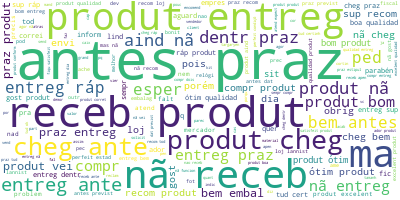

In [52]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(datasetLDA['comentarios'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [53]:
# tokeniza a coluna comentários e cria colunas com bigrams e trigrams
datasetLDA['comentarios'] = datasetLDA['comentarios'].apply(word_tokenize)

datasetLDA.head()

,sentimento,comentarios
0,positive,"[receb, bem, antes, praz, estipul]"
1,positive,"[parabéns, loj, lannist, ador, compr, internet..."
2,positive,"[aparelh, eficient, sit, marc, aparelh, impres..."
3,positive,"[mas, pouc, trav, valor, ta, boa]"
4,positive,"[vendedor, confiável, produt, ok, entreg, ante..."


In [54]:
# carrega funções de bigram e trigram
bigram = gensim.models.Phrases(datasetLDA['comentarios'], min_count=2, threshold=100, delimiter='_') # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[datasetLDA['comentarios']], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [55]:
# Atualiza o dataset com bigrams e trigrams
datasetLDA['comentarios'] = make_bigrams(datasetLDA['comentarios'])

datasetLDA['comentarios'] = make_trigrams(datasetLDA['comentarios'])

datasetLDA

,sentimento,comentarios
0,positive,"[receb, bem, antes, praz, estipul]"
1,positive,"[parabéns, loj, lannist, ador, compr, internet..."
2,positive,"[aparelh, eficient, sit, marc, aparelh, impres..."
3,positive,"[mas, pouc, trav, valor, ta, boa]"
4,positive,"[vendedor, confiável, produt, ok, entreg, ante..."
...,...,...
36683,positive,"[produt, receb, acord, compr, realiz]"
36684,positive,"[entreg, dentr, praz, produt, cheg, condiçõ, p..."
36685,neutral,"[produt, nã, envi, nf, nã, exist, vend, nf, ce..."
36686,positive,"[excelent, mochil, entreg, sup, ráp, sup, reco..."


Cria um dicionário de cada dataset, depois cria um corpus onde é feito o processo de Term Document Frequency, outra etapa necessária para a aplicação do LDA


In [56]:
# divide o dataset em 3, positivo, negativo e neutro
grouped = datasetLDA.groupby(datasetLDA.sentimento)

#cria dataframes para cada sentimento
df_positive = grouped.get_group("positive")
df_negative = grouped.get_group("negative")
df_neutral = grouped.get_group("neutral")

# deleta a coluna 'sentimento' pois não é mais necessária para o experimento
df_positive = df_positive.drop('sentimento', axis=1)
df_negative = df_negative.drop('sentimento', axis=1)
df_neutral = df_neutral.drop('sentimento', axis=1)


df_positive.head()

,comentarios
0,"[receb, bem, antes, praz, estipul]"
1,"[parabéns, loj, lannist, ador, compr, internet..."
2,"[aparelh, eficient, sit, marc, aparelh, impres..."
3,"[mas, pouc, trav, valor, ta, boa]"
4,"[vendedor, confiável, produt, ok, entreg, ante..."


Criando o Dicionário, Corpus e TDF 

In [57]:
df_positive_dic = corpora.Dictionary(df_positive['comentarios'])
df_negative_dic = corpora.Dictionary(df_negative['comentarios'])
df_neutral_dic = corpora.Dictionary(df_neutral['comentarios'])

# Cria um corpus de cada dataset
df_positive_corpus = df_positive['comentarios']
df_negative_corpus = df_negative['comentarios']
df_neutral_corpus = df_neutral['comentarios']

# Term Document Frequency de cada corpus
tdf_positive = [df_positive_dic.doc2bow(text) for text in df_positive_corpus]
tdf_negative = [df_negative_dic.doc2bow(text) for text in df_negative_corpus]
tdf_neutral = [df_neutral_dic.doc2bow(text) for text in df_neutral_corpus]


pprint(df_positive_dic)
# View
pprint(tdf_positive)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)],
 [(5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 2),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1)],
 [(16, 3),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 2),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1)],
 [(28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)],
 [(0, 1), (3, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)],
 [(10, 1), (39, 1)],
 [(40, 1), (41, 1), (42, 1), (43, 1)],
 [(0, 1),
  (3, 1),
  (6, 1),
  (35, 1),
  (37, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1)],
 [(52, 1), (53, 1), (54, 1)],
 [(3, 1),
  (4, 1),
  (18, 1),
  (25, 1),
  (29, 1),
  (38, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(60, 1)],
 [(28, 1)],
 [(10, 1), (34, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)],
 [(66, 1), (67, 1)],
 [(0, 1), (3, 1), (5, 1), (18, 1), (37, 1), (38, 1), (68, 1), (69, 1)],
 [(6, 1), (21, 1), (70, 1), (71, 1)],
 [(72, 1), (73

# Aplicando Lattent Dirilech Allocation

LDA Dataset Positivo


In [58]:
# Build LDA model
lda_model_positive = gensim.models.LdaMulticore(corpus=tdf_positive,
                                                id2word=df_positive_dic,
                                                num_topics=num_topics,
                                                passes=10,
                                                per_word_topics=True)

# Print the Keyword in the n topics
pprint(lda_model_positive.print_topics())
doc_lda = lda_model_positive[tdf_positive]

[(0,
  '0.098*"produt" + 0.075*"bom" + 0.067*"recom" + 0.059*"entreg" + 0.037*"tud" '
  '+ 0.035*"praz" + 0.031*"antes" + 0.028*"excelent" + 0.024*"conform" + '
  '0.022*"cheg"'),
 (1,
  '0.130*"praz" + 0.103*"produt" + 0.093*"antes" + 0.085*"entreg" + '
  '0.065*"cheg" + 0.038*"bem" + 0.023*"qualidad" + 0.021*"dentr" + '
  '0.019*"satisfeit" + 0.017*"previst"'),
 (2,
  '0.112*"produt" + 0.075*"entreg" + 0.057*"ótim" + 0.055*"ráp" + '
  '0.049*"excelent" + 0.032*"perfeit" + 0.029*"qualidad" + 0.019*"parabéns" + '
  '0.019*"gost" + 0.017*"loj"'),
 (3,
  '0.054*"produt" + 0.031*"cheg" + 0.025*"mas" + 0.025*"receb" + 0.024*"tud" + '
  '0.022*"dia" + 0.022*"cert" + 0.022*"vei" + 0.021*"aind" + 0.017*"praz"'),
 (4,
  '0.043*"receb" + 0.041*"compr" + 0.032*"produt" + 0.029*"atend" + '
  '0.027*"tud" + 0.026*"bem" + 0.026*"perfeit" + 0.025*"praz" + 0.019*"entreg" '
  '+ 0.018*"ok"'),
 (5,
  '0.098*"sup" + 0.057*"entreg" + 0.044*"ráp" + 0.044*"recom" + 0.033*"produt" '
  '+ 0.027*"lind" + 0.02

LDA Dataset Negativo

In [59]:
# Build LDA model
lda_model_negative = gensim.models.LdaMulticore(corpus=tdf_negative,
                                                id2word=df_negative_dic,
                                                num_topics=num_topics,
                                                passes=10,
                                                per_word_topics=True)

# Print the Keyword in the n topics
pprint(lda_model_negative.print_topics())
doc_lda = lda_model_negative[tdf_negative]

[(0,
  '0.054*"receb" + 0.051*"produt" + 0.047*"nã" + 0.036*"vei" + 0.030*"compr" + '
  '0.023*"ped" + 0.016*"errad" + 0.014*"outr" + 0.014*"troc" + 0.012*"dois"'),
 (1,
  '0.054*"correi" + 0.033*"nã" + 0.025*"produt" + 0.025*"fret" + 0.022*"cheg" '
  '+ 0.022*"cas" + 0.021*"compr" + 0.016*"retir" + 0.015*"receb" + '
  '0.014*"entreg"'),
 (2,
  '0.078*"nã" + 0.044*"receb" + 0.032*"compr" + 0.025*"produt" + 0.017*"cheg" '
  '+ 0.015*"unidad" + 0.015*"aind" + 0.014*"falt" + 0.011*"gost" + '
  '0.011*"sab"'),
 (3,
  '0.081*"produt" + 0.073*"nã" + 0.024*"vei" + 0.019*"receb" + 0.019*"cheg" + '
  '0.014*"diferent" + 0.012*"compr" + 0.011*"fot" + 0.010*"gost" + '
  '0.010*"outr"'),
 (4,
  '0.074*"nã" + 0.062*"produt" + 0.026*"entreg" + 0.025*"loj" + 0.017*"compr" '
  '+ 0.016*"receb" + 0.016*"péssim" + 0.016*"qualidad" + 0.009*"correi" + '
  '0.008*"atend"'),
 (5,
  '0.090*"nã" + 0.073*"produt" + 0.063*"entreg" + 0.046*"receb" + '
  '0.035*"compr" + 0.030*"aind" + 0.019*"praz" + 0.018*"cheg"

LDA Dataset Neutro

In [60]:
# Build LDA model
lda_model_neutral = gensim.models.LdaMulticore(corpus=tdf_neutral,
                                                id2word=df_neutral_dic,
                                                num_topics=num_topics,
                                                passes=10,
                                                per_word_topics=True)

# Print the Keyword in the n topics
pprint(lda_model_neutral.print_topics())
doc_lda = lda_model_neutral[tdf_neutral]

[(0,
  '0.046*"nã" + 0.035*"produt" + 0.034*"receb" + 0.028*"vei" + 0.023*"compr" + '
  '0.018*"falt" + 0.017*"entreg" + 0.013*"problem" + 0.011*"cartuch" + '
  '0.011*"outr"'),
 (1,
  '0.060*"nã" + 0.038*"produt" + 0.035*"compr" + 0.029*"aind" + 0.027*"receb" '
  '+ 0.020*"vei" + 0.015*"gost" + 0.015*"nao" + 0.013*"cheg" + 0.012*"mas"'),
 (2,
  '0.068*"nã" + 0.050*"produt" + 0.033*"bom" + 0.022*"mas" + 0.014*"esper" + '
  '0.014*"qualidad" + 0.014*"fot" + 0.011*"porém" + 0.010*"correi" + '
  '0.009*"bem"'),
 (3,
  '0.060*"produt" + 0.044*"vei" + 0.023*"nã" + 0.021*"praz" + 0.019*"receb" + '
  '0.016*"dentr" + 0.016*"part" + 0.014*"cor" + 0.013*"porém" + '
  '0.013*"entreg"'),
 (4,
  '0.061*"produt" + 0.034*"nã" + 0.034*"entreg" + 0.033*"praz" + 0.028*"mas" + '
  '0.024*"cheg" + 0.014*"pouc" + 0.014*"correi" + 0.012*"antes" + '
  '0.011*"aind"'),
 (5,
  '0.046*"produt" + 0.033*"compr" + 0.028*"entreg" + 0.022*"cheg" + '
  '0.019*"unidad" + 0.016*"nã" + 0.015*"receb" + 0.013*"ped" + 0.0

In [61]:
#Calculos das métricas da LDA

# POSITIVO
print()
print('Positive')  
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_positive, texts=df_positive['comentarios'], dictionary=df_positive_dic, coherence='c_v')
coherence_lda_positive = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_positive)

coherence_model_ldaTeste = CoherenceModel(model=lda_model_positive, texts=df_positive['comentarios'], dictionary=df_positive_dic, coherence='u_mass')
coherence_lda_positiveTeste = coherence_model_ldaTeste.get_coherence()
print('\nCoherence Score u mass: ', coherence_lda_positiveTeste)


#NEGATIVE
print()
print('Negative')  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_negative, texts=df_negative['comentarios'], dictionary=df_negative_dic, coherence='c_v')
coherence_lda_negativo = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda_negativo)

coherence_model_ldaTeste = CoherenceModel(model=lda_model_negative, texts=df_negative['comentarios'], dictionary=df_negative_dic, coherence='u_mass')
coherence_lda_negativoTeste = coherence_model_ldaTeste.get_coherence()
print('\nCoherence Score u mass: ', coherence_lda_negativoTeste)


#NEUTRAL
print()
print('Neutral')  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_neutral, texts=df_neutral['comentarios'], dictionary=df_neutral_dic, coherence='c_v')
coherence_lda_neutral = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda_neutral)

coherence_model_ldaTeste = CoherenceModel(model=lda_model_neutral, texts=df_neutral['comentarios'], dictionary=df_neutral_dic, coherence='u_mass')
coherence_lda_neutralTeste = coherence_model_ldaTeste.get_coherence()
print('\nCoherence Score u mass: ', coherence_lda_neutralTeste)


Positive

Coherence Score:  0.33468779028927886

Coherence Score u mass:  -2.9882871726920555

Negative
Coherence Score:  0.34574231246465725

Coherence Score u mass:  -3.064885145269131

Neutral
Coherence Score:  0.32733232676680657

Coherence Score u mass:  -3.220468863803844


Inicialização da visualização do LDA


In [62]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./visualLDA'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_positive, tdf_positive, df_positive_dic)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './visualLDA_Positive'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.162891  0.076187       1        1  24.592722
6     -0.226044  0.045793       2        1  15.413719
0      0.130879  0.052929       3        1  13.489694
2      0.081027 -0.101453       4        1  11.081581
3     -0.065381  0.139173       5        1   9.791887
7     -0.176863 -0.102245       6        1   9.656009
5      0.068997 -0.158333       7        1   8.612514
4      0.024495  0.047949       8        1   7.361874, topic_info=      Term         Freq        Total Category  logprob  loglift
64     sup  1542.000000  1542.000000  Default  30.0000  30.0000
3     praz  6198.000000  6198.000000  Default  29.0000  29.0000
0    antes  4613.000000  4613.000000  Default  28.0000  28.0000
111    ráp  2083.000000  2083.000000  Default  27.0000  27.0000
6    compr  3407.000000  3407.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
10     loj   118.443493  1567.248167   Topic8  -4.5204   0.0262
26     sit    79.024950   422.716098   Topic8  -4.9251   0.9319
146  dentr    97.433414  1084.675330   Topic8  -4.7157   0.1990
89   embal    77.744278   741.908460   Topic8  -4.9414   0.3531
18    cheg    76.483941  4038.945421   Topic8  -4.9578  -1.3578

[638 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1132      4  0.930187   abaix
1810      5  0.971907   abril
4813      4  0.956536     abs
1439      6  0.952332  absurd
167       1  0.019366    acab
...     ...       ...     ...
95        7  0.064779    ótim
95        8  0.000476    ótim
5527      4  0.950278    ötim
1034      4  0.033302     úte
1034      6  0.932466     úte

[1383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 1, 3, 4, 8, 6, 5])

In [63]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./visualLDA'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_negative, tdf_negative, df_negative_dic)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './visualLDA_Negative'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.016192  0.095712       1        1  28.263881
3     -0.036350 -0.081398       2        1  13.060594
0     -0.073827 -0.076702       3        1  12.957087
6     -0.025043 -0.035792       4        1  12.139446
4      0.008643  0.051786       5        1  10.927238
2     -0.022021  0.063143       6        1   8.917424
7     -0.027008  0.017426       7        1   8.665137
1      0.191799 -0.034174       8        1   5.069192, topic_info=       Term         Freq        Total Category  logprob  loglift
94   correi   535.000000   535.000000  Default  30.0000  30.0000
110     vei  1413.000000  1413.000000  Default  29.0000  29.0000
9        nã  6968.000000  6968.000000  Default  28.0000  28.0000
14   entreg  3250.000000  3250.000000  Default  27.0000  27.0000
1     compr  3279.000000  3279.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
356     sit    32.209741   481.082585   Topic8  -5.1587   0.2782
406     dev    26.201059   265.996341   Topic8  -5.3652   0.6643
336       q    24.360323   284.315656   Topic8  -5.4381   0.5249
11     aind    29.061552  1313.080610   Topic8  -5.2616  -0.8287
225    pois    25.075964   492.552040   Topic8  -5.4091   0.0043

[639 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4046      8  0.663948  abdominal
2827      4  0.772807  abri_cham
1341      1  0.821450      abril
49        1  0.079408       acab
49        2  0.357334       acab
...     ...       ...        ...
2761      4  0.151833      ítens
2761      6  0.759167      ítens
154       1  0.834349        úte
154       3  0.043913        úte
154       4  0.087826        úte

[1905 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 1, 7, 5, 3, 8, 2])

In [64]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./visualLDA'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_neutral, tdf_neutral, df_neutral_dic)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './visualLDA_Neutral'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.063657  0.056372       1        1  18.884718
6     -0.035940  0.043840       2        1  16.435987
1     -0.045999 -0.013924       3        1  13.205343
2      0.093586 -0.073628       4        1  13.159619
5     -0.058713  0.085579       5        1   9.979879
3      0.034521 -0.079530       6        1   9.934979
4      0.067107  0.052853       7        1   9.774814
0     -0.118220 -0.071564       8        1   8.624660, topic_info=      Term         Freq        Total Category  logprob  loglift
16    praz   434.000000   434.000000  Default  30.0000  30.0000
14     vei   486.000000   486.000000  Default  29.0000  29.0000
4    receb   606.000000   606.000000  Default  28.0000  28.0000
11      nã  1222.000000  1222.000000  Default  27.0000  27.0000
7      bom   274.000000   274.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
262   marc     9.575565    28.907089   Topic8  -5.6230   1.3457
35    aind    14.479729   253.920775   Topic8  -5.2095  -0.4137
29     loj    12.175817   171.471465   Topic8  -5.3828  -0.1944
94     ter    11.371434   104.346705   Topic8  -5.4511   0.2339
133    fic    11.361583   128.292580   Topic8  -5.4520   0.0265

[612 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1547      8  0.737974     aba
366       1  0.302229  absurd
366       7  0.604457  absurd
105       1  0.208372    acab
105       2  0.052093    acab
...     ...       ...     ...
164       3  0.027966    ótim
164       4  0.111866    ótim
164       5  0.335597    ótim
164       6  0.027966    ótim
164       7  0.013983    ótim

[1496 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 2, 3, 6, 4, 5, 1])